## 6b. Advanced Modelling - Chicago Marathon
__Project - BSTN Capstone__
<br>__Beth McGregor__

#### Introduction
This notebook follows __6a. Advanced Modelling - London Marathon__. First, the all features data for the Chicago Marathon will be loaded, transformed and used for advanced modelling to see if improvement can be achieved. 

In [2]:
# Load the required libraries for this notebook

import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy import stats
import statsmodels.api as sm
## Tukey's HSD
from statsmodels.stats import multicomp

# Data Transformation
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import joblib

#### Look at a reduced dataset (Chicago only) with additional features

In [3]:
# Load in the london all features dataset
chicago_all_features_df = pd.read_csv('Data/chicago/output/chicago_results_all_features.csv')
chicago_all_features_df.head()

,Unnamed: 0,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,nationality,gender,...,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
0,0,chicago,2019,1,Lawrence Cherono,4,18-39,1,KEN,M,...,182.94,182.82,3.8,-5.9,57.91,-58.03,42,3.3,13.3,0.0
1,1,chicago,2019,2,Dejene Debela,38,18-39,1,ETH,M,...,182.94,182.82,3.8,-5.9,57.91,-58.03,42,3.3,13.3,0.0
2,2,chicago,2019,3,Asefa Mengstu,5,18-39,1,ETH,M,...,182.94,182.82,3.8,-5.9,57.91,-58.03,42,3.3,13.3,0.0
3,3,chicago,2019,4,Bedan Karoki,9,18-39,1,KEN,M,...,182.94,182.82,3.8,-5.9,57.91,-58.03,42,3.3,13.3,0.0
4,4,chicago,2019,5,Bashir Abdi,10,18-39,1,BEL,M,...,182.94,182.82,3.8,-5.9,57.91,-58.03,42,3.3,13.3,0.0


In [4]:
# Drop the 'Unnamed: 0' column
chicago_all_features_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
# Get the shape of the dataframe
chicago_all_features_df.shape

(253365, 20)

The Chicago Marathon dataframe consists of 20 columns and 253,365 rows. 

In [6]:
# Look at the data types
chicago_all_features_df.dtypes

marathon_name           object
year                     int64
place_overall            int64
full_name               object
bib_number               int64
age_class               object
elite_status             int64
nationality             object
gender                  object
finish_time_seconds      int64
altitude_start         float64
altitude_finish        float64
max_slope              float64
min_slope              float64
elevation_gain         float64
elevation_loss         float64
course_turns             int64
temperature_min        float64
temperature_max        float64
precipitation          float64
dtype: object

Data types appear to be appropriate. 

In [7]:
# Check that there are no missing values
chicago_all_features_df.isna().sum()

marathon_name          0
year                   0
place_overall          0
full_name              0
bib_number             0
age_class              0
elite_status           0
nationality            0
gender                 0
finish_time_seconds    0
altitude_start         0
altitude_finish        0
max_slope              0
min_slope              0
elevation_gain         0
elevation_loss         0
course_turns           0
temperature_min        0
temperature_max        0
precipitation          0
dtype: int64

There are no missing values. 

#### Start to Explore the Numeric Columns: 

In [8]:
chicago_numeric_columns_df = chicago_all_features_df[['year', 'place_overall', 'bib_number', 'elite_status', 'finish_time_seconds', 'altitude_start', 'altitude_finish', 'max_slope', 'min_slope', 'elevation_gain', 'elevation_loss', 'course_turns', 'temperature_min', 'temperature_max', 'precipitation' ]]


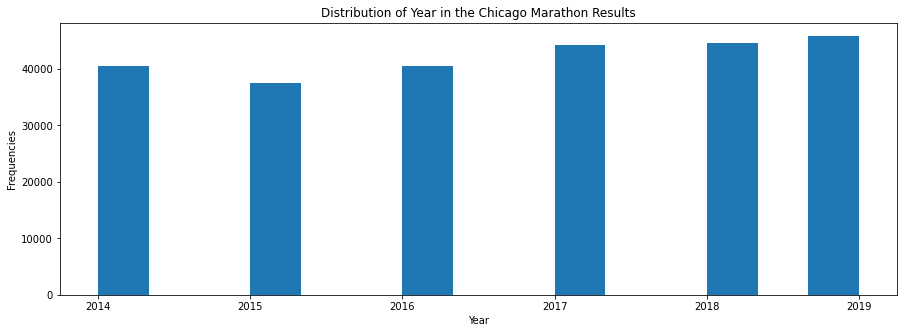

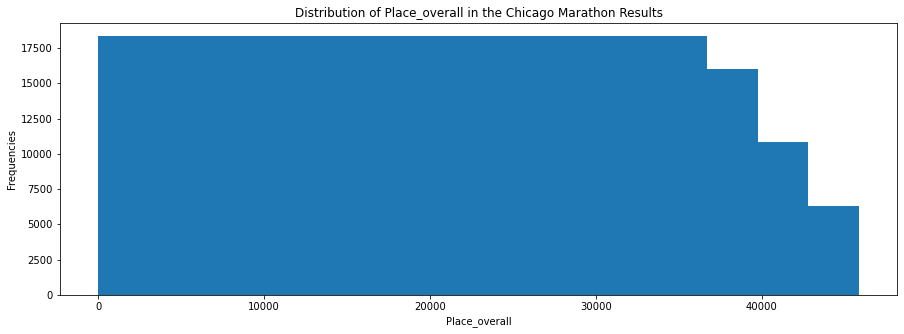

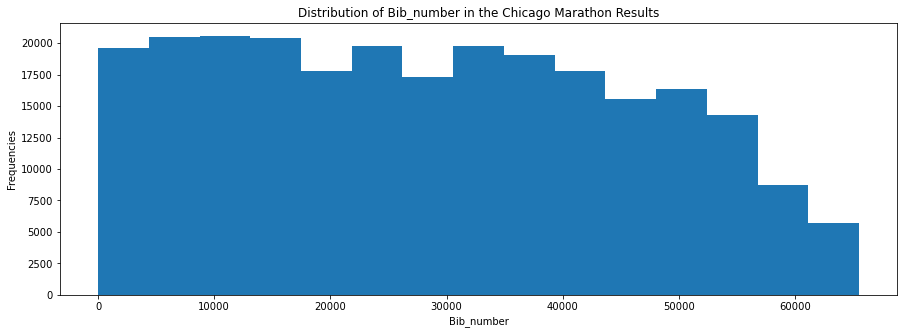

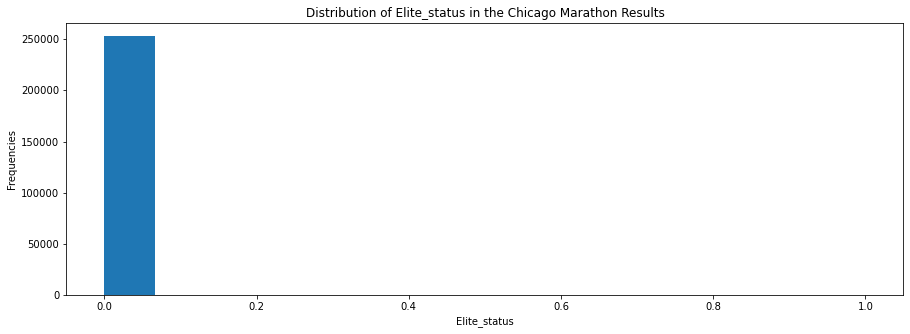

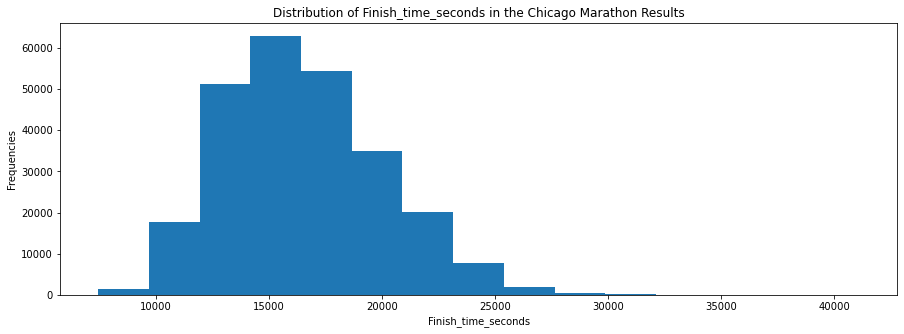

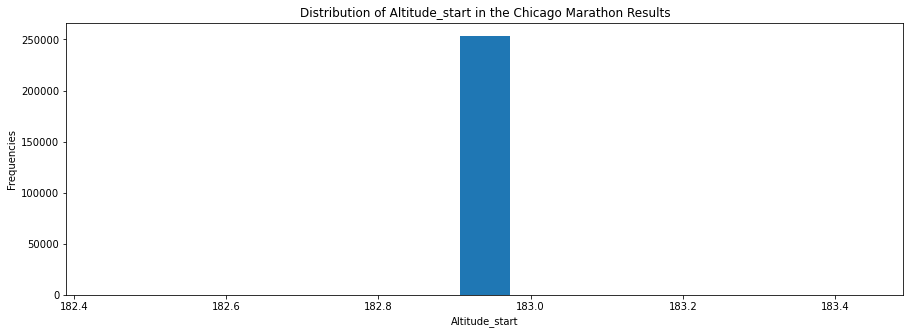

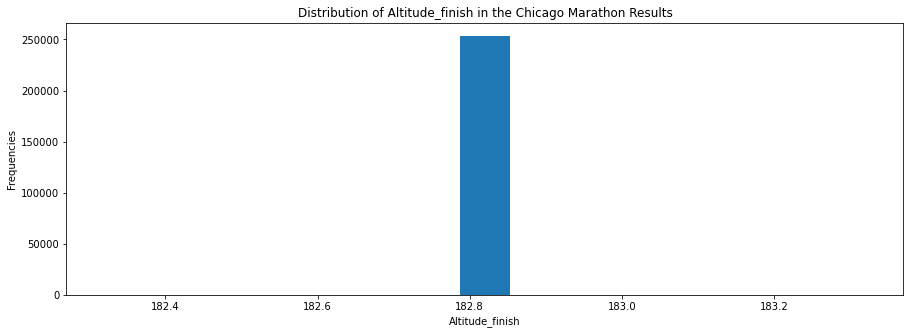

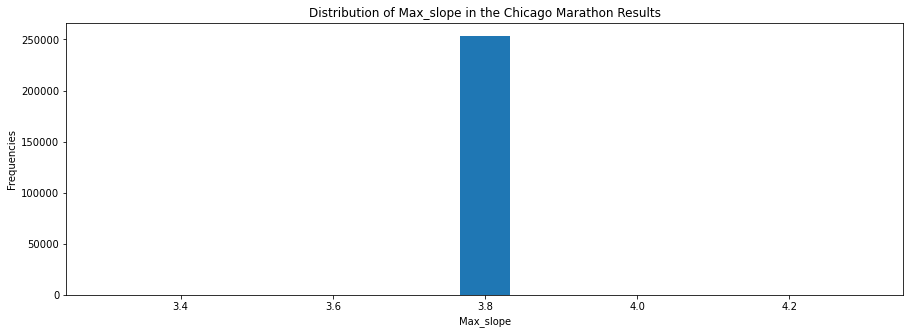

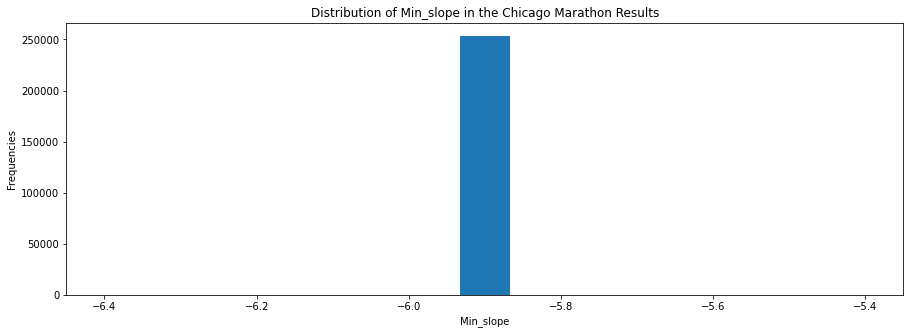

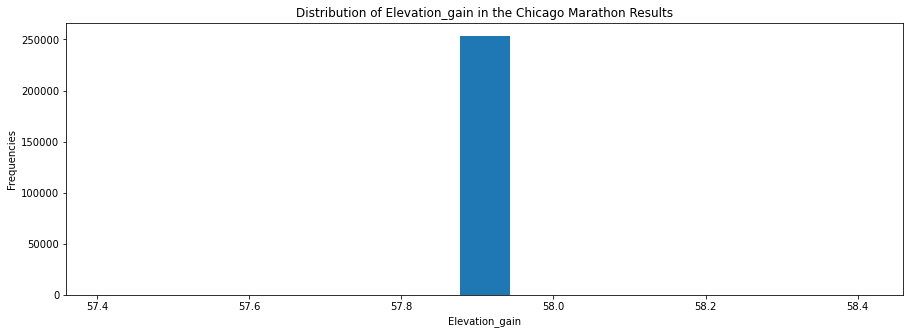

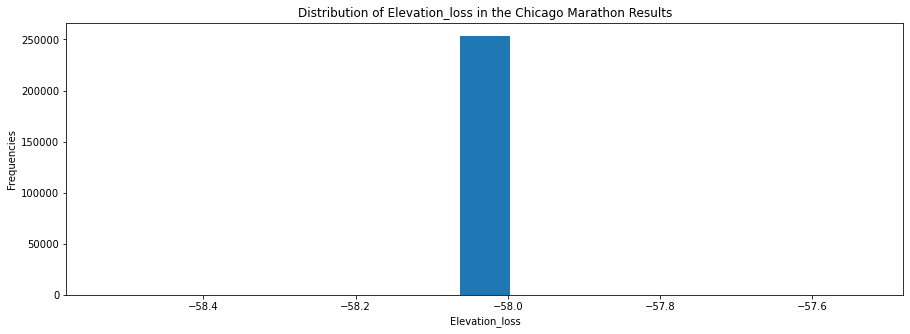

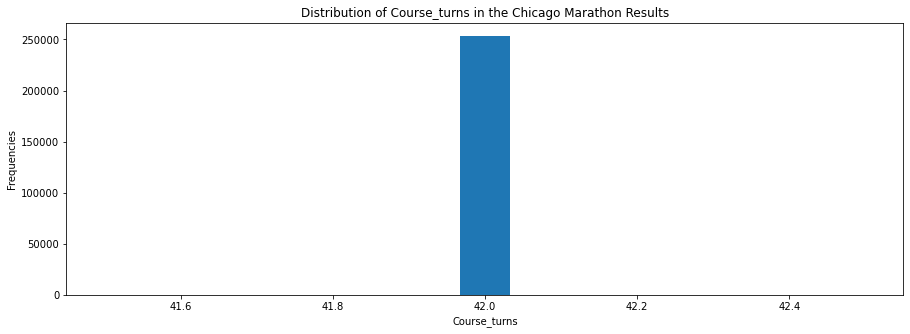

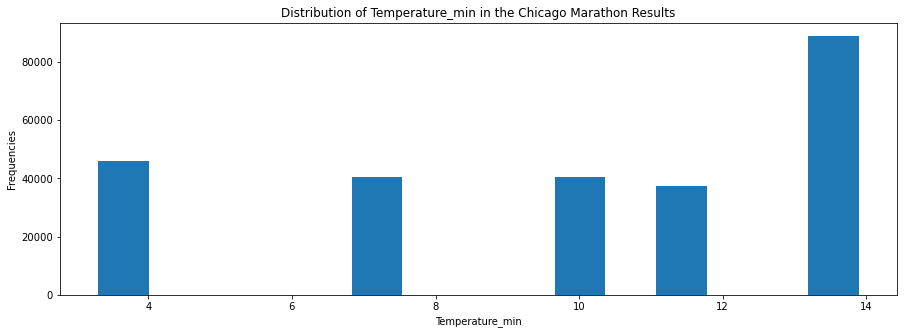

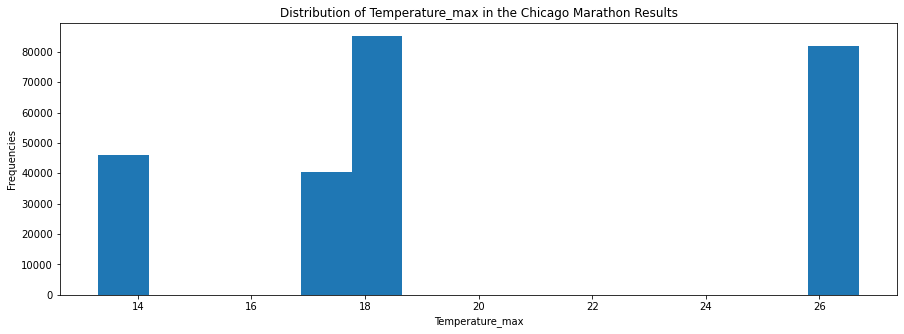

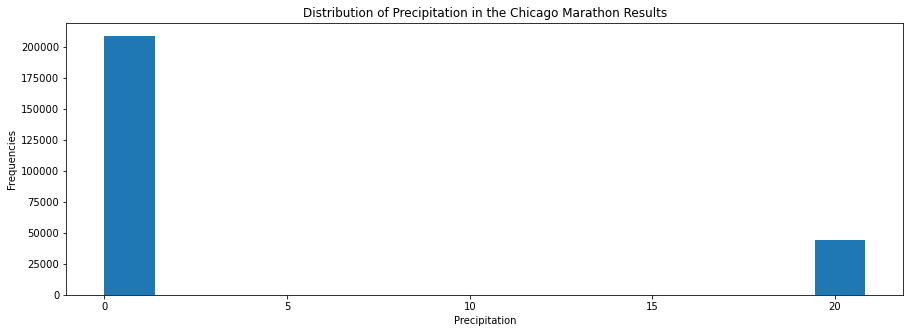

In [9]:
for col in chicago_numeric_columns_df:

    plt.figure(figsize=(15,5))
    plt.hist(chicago_numeric_columns_df[col], bins=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequencies")
    plt.title(f"Distribution of {col.capitalize()} in the Chicago Marathon Results")
    plt.show()

The trends observed in the above plots follow the trends observed in the combined dataset. 

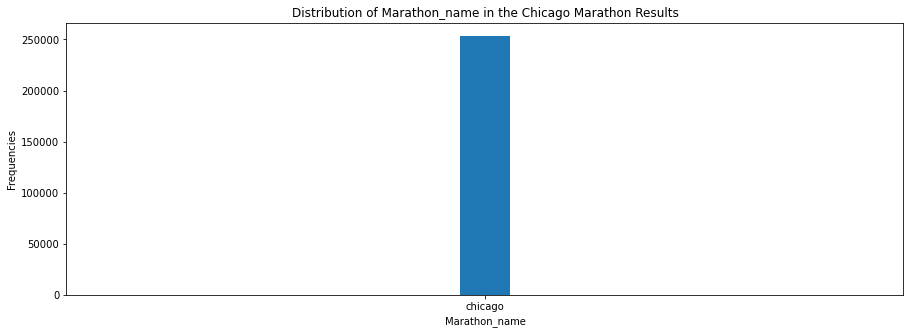

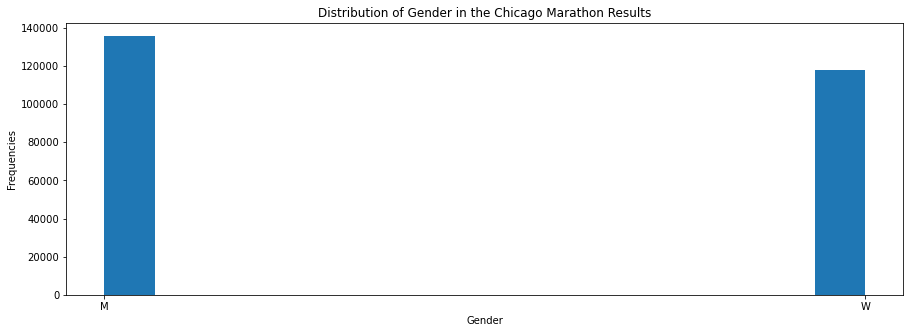

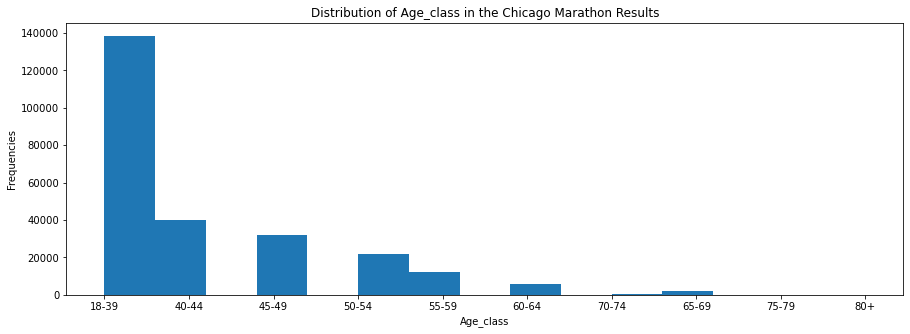

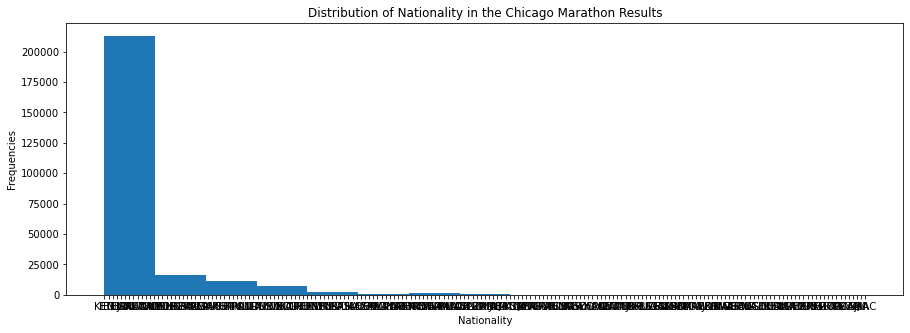

In [10]:
# Look at the distribution of data in the categorical columns
chicago_categorical_columns_df = chicago_all_features_df[['marathon_name', 'gender', 'age_class', 'nationality']]

for col in chicago_categorical_columns_df:

    plt.figure(figsize=(15,5))
    plt.hist(chicago_categorical_columns_df[col], bins=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequencies")
    plt.title(f"Distribution of {col.capitalize()} in the Chicago Marathon Results")
    plt.show()

The majority of runners fall in the 18-39 age category, with progressively fewer runners in the older age categories. Gender appears to be a slightly more even split vs. the London Marathon.

#### Update the country codes in the nationality column to the IOC country codes

In [11]:
# Create a dictionary of the nationality country codes that need to be replaced (Used IOC Country Codes)

ioc_codes = {'DEU' : 'GER', 'ZWE' : 'ZIM', 'ZAF' : 'RSA', 'WLS' : 'GBR', 'WLF' : 'FRA', 'VNM' : 'VIE', 
             'URY' : 'URU', 'UMI' : 'USA', 'ARE' : 'UAE', 'TWN' : 'TPE', 'TRI' : 'TTO', 'TGO' : 'TOG',
             'TCA' : 'GBR', 'SVN' : 'SLO', 'CHE' : 'SUI', 'SDN' : 'SUD', 'SPM' : 'FRA', 'SLV' : 'ESA', 
             'SJM' : 'NOR', 'SIN' : 'SGP', 'SHN' : 'GBR', 'SGS' : 'GBR', 'SCO' : 'GBR', 'RKS' : 'KOS', 
             'REU' : 'FRA', 'PYF' : 'FRA', 'PRI' : 'PUR', 'PAR' : 'PRY', 'PRT' : 'POR', 'PHI' : 'PHL', 
             'OMA' : 'OMN', 'NEP' : 'NPL', 'NLD' : 'NED', 'NGA' : 'NGR', 'NIR' : 'GBR', 'NCL' : 'FRA', 
             'MYT' : 'FRA', 'MYS' : 'MAS', 'MYA' : 'MMR', 'MTQ' : 'FRA', 'MNG' : 'MGL', 'MAF' : 'FRA', 
             'MAC' : 'CHN', 'LVA' : 'LAT', 'LES' : 'LSO', 'LBY' : 'LBA', 'LIB' : 'LBN', 'KNA' : 'SKN', 
             'JEY' : 'GBR', 'IVB' : 'GBR', 'ISV' : 'USA', 'IRN' : 'IRI', 'IOT' : 'GBR', 'IDN' : 'INA', 
             'IMN' : 'GBR', 'HRV' : 'CRO', 'HND' : 'HON', 'GTM' : 'GUA', 'GRL' : 'GRD', 'GRC' : 'GRE', 
             'GLP' : 'FRA', 'GIB' : 'GBR', 'GGY' : 'GBR', 'FRO' : 'DEN' ,'DNK' : 'DEN', 'ENG' : 'GBR',
             'FLK' : 'GBR', 'DZA' : 'ALG', 'CUW' : 'NED', 'CRI' : 'CRC', 'CHL' : 'CHI', 'BGR' : 'BUL',
             'BRN' : 'BRU', 'BHS' : 'BAH', 'ABW' : 'ARU', 'ALA' : 'FIN', 'AIA' : 'GBR'
}

# Update nationality country codes

def update_country_code(original):
    if original in ioc_codes:
        return ioc_codes[original]
    return original

# Replace the above country codes in the nationality column
chicago_all_features_df['nationality'] = chicago_all_features_df['nationality'].apply(update_country_code)


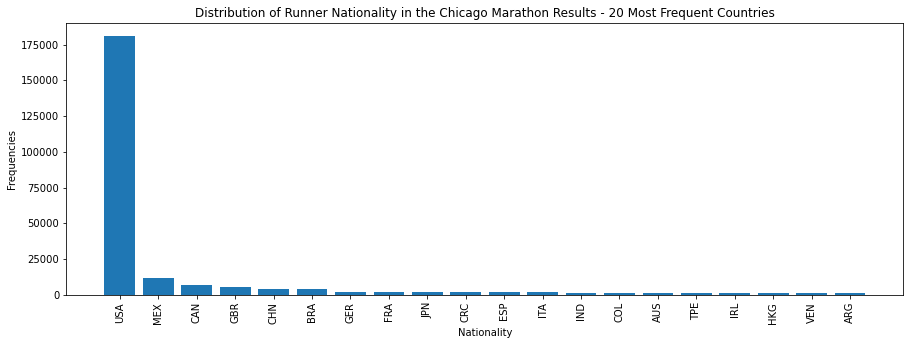

In [12]:
# Re-plot the nationality column with the top 20 nationalities by frequency

plt.figure(figsize=(15,5))
plt.bar(chicago_all_features_df["nationality"].value_counts().head(20).index, chicago_all_features_df["nationality"].value_counts().head(20).values)
plt.xlabel('Nationality')
plt.ylabel("Frequencies")
plt.title('Distribution of Runner Nationality in the Chicago Marathon Results - 20 Most Frequent Countries')
plt.xticks(rotation='vertical')
plt.show()

The majority of runners participating in the Chicago Marathon from 2014-2019 are from the US. 

#### Explore the distribution of finish time for the Chicago marathon results

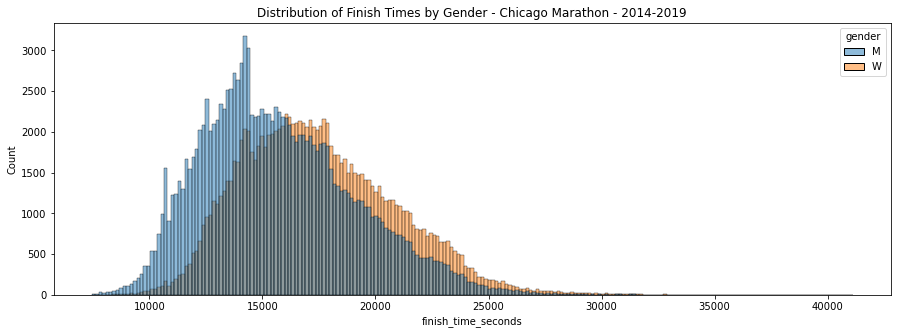

In [13]:
# Plot finish time by gender
plt.figure(figsize=(15,5))
finish_time_gender = chicago_all_features_df[['finish_time_seconds', 'gender']]
sns.histplot(x = 'finish_time_seconds', hue = 'gender', data=finish_time_gender)
plt.title('Distribution of Finish Times by Gender - Chicago Marathon - 2014-2019')
plt.show()

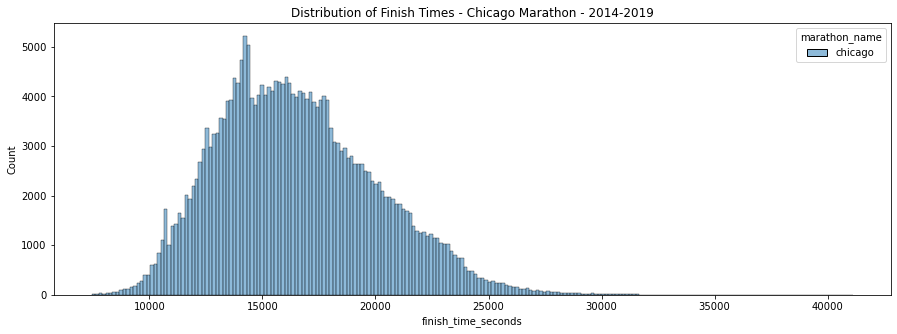

In [14]:
# Plot the distribution of finish times for the Chicago Marathon 2014-2019
plt.figure(figsize = (15,5))
finish_time_marathon = chicago_all_features_df[['marathon_name', 'finish_time_seconds', 'year', 'gender']]
sns.histplot(x = 'finish_time_seconds', hue = 'marathon_name', data = finish_time_marathon)
plt.title('Distribution of Finish Times - Chicago Marathon - 2014-2019')
plt.show()

### Data Transformation
- To Do List: 
    - Binarize the gender column
    - One Hot Encode the Nationality column
    - One Hot Encode the Nationality column
    - Drop columns that will not be used for modelling

#### Binarize the gender column

In [15]:
# Convert the gender column to binary 
# Male -> 0
# Female -> 1

chicago_all_features_df['gender'] = chicago_all_features_df['gender'].apply(lambda x: 0 if x == 'M' else 1)

# Confirm that the gender column has been converted to binary

chicago_all_features_df['gender'].describe()

count    253365.000000
mean          0.464302
std           0.498725
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: gender, dtype: float64

#### One Hot Encode the Nationality Column

In [16]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
runner_nationality = pd.DataFrame(chicago_all_features_df['nationality'])
encoded_runner_nationality = ohe.fit_transform(runner_nationality)
encoded_runner_nationality

<253365x168 sparse matrix of type '<class 'numpy.float64'>'
	with 253365 stored elements in Compressed Sparse Row format>

In [17]:
dense_array = encoded_runner_nationality.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
ohe.categories_

[array(['AFG', 'ALB', 'ALG', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ARU',
        'ASA', 'AUS', 'AUT', 'AZE', 'BAH', 'BAN', 'BAR', 'BDI', 'BEL',
        'BER', 'BHU', 'BIH', 'BIZ', 'BLR', 'BOL', 'BOT', 'BRA', 'BRU',
        'BUL', 'CAM', 'CAN', 'CAY', 'CHA', 'CHI', 'CHN', 'CMR', 'COD',
        'COL', 'COM', 'CPV', 'CRC', 'CRO', 'CUB', 'CYP', 'CZE', 'DEN',
        'DMA', 'DOM', 'ECU', 'EGY', 'ERI', 'ESA', 'ESP', 'EST', 'ETH',
        'FIN', 'FRA', 'FSM', 'GAM', 'GBR', 'GBS', 'GEO', 'GER', 'GHA',
        'GRE', 'GRN', 'GUA', 'GUI', 'GUM', 'GUY', 'HAI', 'HKG', 'HON',
        'HUN', 'INA', 'IND', 'IRI', 'IRL', 'IRQ', 'ISL', 'ISR', 'ITA',
        'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KOR', 'KSA', 'KUW',
        'LAT', 'LBN', 'LCA', 'LIE', 'LTU', 'LUX', 'MAD', 'MAR', 'MAS',
        'MAW', 'MDA', 'MEX', 'MGL', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE',
        'MON', 'MRI', 'MTN', 'NAM', 'NCA', 'NED', 'NGR', 'NIG', 'NOR',
        'NPL', 'NZL', 'PAK', 'PAN', 'PER', 'PHL', 'PLE', 'PLW', 'POL',
      

In [19]:
# Put into a dataframe to get column names
encoded_runner_nationality_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_runner_nationality_df.index = runner_nationality.index

# Add original back in (just to check)
encoded_runner_nationality_df['runner_nationality'] = chicago_all_features_df['nationality']

# Show
encoded_runner_nationality_df.head()

,AFG,ALB,ALG,AND,ANG,ANT,ARG,ARM,ARU,ASA,...,URU,USA,UZB,Unknown,VEN,VIE,VIN,ZAM,ZIM,runner_nationality
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,KEN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ETH
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ETH
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,KEN
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,BEL


In [20]:
# Check the dimension of the encoded_runner_nationality and the original marathon_df to ensure that they are the same

print(encoded_runner_nationality_df.shape, 
      chicago_all_features_df.shape)


(253365, 169) (253365, 20)


In [21]:
# Concatenate the encoded_runner_nationality_df with the marathon_df
chicago_all_features_df_ohe = pd.concat([chicago_all_features_df, encoded_runner_nationality_df], axis=1)

In [22]:
# Have a look at the concateated dataframe
chicago_all_features_df_ohe.head()

,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,nationality,gender,finish_time_seconds,...,URU,USA,UZB,Unknown,VEN,VIE,VIN,ZAM,ZIM,runner_nationality
0,chicago,2019,1,Lawrence Cherono,4,18-39,1,KEN,0,7545,...,0,0,0,0,0,0,0,0,0,KEN
1,chicago,2019,2,Dejene Debela,38,18-39,1,ETH,0,7546,...,0,0,0,0,0,0,0,0,0,ETH
2,chicago,2019,3,Asefa Mengstu,5,18-39,1,ETH,0,7548,...,0,0,0,0,0,0,0,0,0,ETH
3,chicago,2019,4,Bedan Karoki,9,18-39,1,KEN,0,7553,...,0,0,0,0,0,0,0,0,0,KEN
4,chicago,2019,5,Bashir Abdi,10,18-39,1,BEL,0,7574,...,0,0,0,0,0,0,0,0,0,BEL


#### One Hot Encode the Marathon Name Column

In [23]:
# Instantiate the OneHotEncoder for converting marathon_name 
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame

marathon_name = pd.DataFrame(chicago_all_features_df['marathon_name'])
encoded_marathon_name = ohe.fit_transform(marathon_name)
encoded_marathon_name

<253365x1 sparse matrix of type '<class 'numpy.float64'>'
	with 253365 stored elements in Compressed Sparse Row format>

In [24]:
dense_array = encoded_marathon_name.toarray()
dense_array

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [25]:
ohe.categories_

[array(['chicago'], dtype=object)]

In [26]:
# Put into a dataframe to get column names
encoded_marathon_name_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_marathon_name_df.index = marathon_name.index

# Add original back in (just to check)
encoded_marathon_name_df['marathon_name'] = chicago_all_features_df['marathon_name']

# Show
encoded_marathon_name_df.head()

,chicago,marathon_name
0,1,chicago
1,1,chicago
2,1,chicago
3,1,chicago
4,1,chicago


In [27]:
# Check the dimension of the encoded_marathon_name_df and the original marathon_df to ensure that they are the same

print(encoded_marathon_name_df.shape, 
      chicago_all_features_df.shape)


(253365, 2) (253365, 20)


In [28]:
# Concatenate the encoded_marathon_name_df with the marathon_df_ohe
chicago_all_features_df_ohe = pd.concat([chicago_all_features_df_ohe, encoded_marathon_name_df], axis=1)

In [29]:
# Have a look at the concateated dataframe
chicago_all_features_df_ohe.head()

,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,nationality,gender,finish_time_seconds,...,UZB,Unknown,VEN,VIE,VIN,ZAM,ZIM,runner_nationality,chicago,marathon_name
0,chicago,2019,1,Lawrence Cherono,4,18-39,1,KEN,0,7545,...,0,0,0,0,0,0,0,KEN,1,chicago
1,chicago,2019,2,Dejene Debela,38,18-39,1,ETH,0,7546,...,0,0,0,0,0,0,0,ETH,1,chicago
2,chicago,2019,3,Asefa Mengstu,5,18-39,1,ETH,0,7548,...,0,0,0,0,0,0,0,ETH,1,chicago
3,chicago,2019,4,Bedan Karoki,9,18-39,1,KEN,0,7553,...,0,0,0,0,0,0,0,KEN,1,chicago
4,chicago,2019,5,Bashir Abdi,10,18-39,1,BEL,0,7574,...,0,0,0,0,0,0,0,BEL,1,chicago


#### One Hot Encode the Age Class Column

In [30]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
age_class = pd.DataFrame(chicago_all_features_df['age_class'])
encoded_age_class = ohe.fit_transform(age_class)
encoded_age_class

<253365x10 sparse matrix of type '<class 'numpy.float64'>'
	with 253365 stored elements in Compressed Sparse Row format>

In [31]:
dense_array = encoded_age_class.toarray()
dense_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [32]:
ohe.categories_

[array(['18-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69',
        '70-74', '75-79', '80+'], dtype=object)]

In [33]:
# Put into a dataframe to get column names
encoded_age_class_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_age_class_df.index = age_class.index

# Add original back in (just to check)
encoded_age_class_df['age_class'] = chicago_all_features_df['age_class']

# Show
encoded_age_class_df.head()

,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,age_class
0,1,0,0,0,0,0,0,0,0,0,18-39
1,1,0,0,0,0,0,0,0,0,0,18-39
2,1,0,0,0,0,0,0,0,0,0,18-39
3,1,0,0,0,0,0,0,0,0,0,18-39
4,1,0,0,0,0,0,0,0,0,0,18-39


In [34]:
# Check the dimension of the encoded_runner_nationality and the original marathon_df to ensure that they are the same

print(encoded_age_class_df.shape, 
      chicago_all_features_df.shape)


(253365, 11) (253365, 20)


In [35]:
# Concatenate the encoded_runner_nationality_df with the marathon_df
chicago_all_features_df_ohe = pd.concat([chicago_all_features_df_ohe, encoded_age_class_df], axis=1)

In [36]:
# Have a look at the concateated dataframe
chicago_all_features_df_ohe.head()

,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,nationality,gender,finish_time_seconds,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,age_class
0,chicago,2019,1,Lawrence Cherono,4,18-39,1,KEN,0,7545,...,0,0,0,0,0,0,0,0,0,18-39
1,chicago,2019,2,Dejene Debela,38,18-39,1,ETH,0,7546,...,0,0,0,0,0,0,0,0,0,18-39
2,chicago,2019,3,Asefa Mengstu,5,18-39,1,ETH,0,7548,...,0,0,0,0,0,0,0,0,0,18-39
3,chicago,2019,4,Bedan Karoki,9,18-39,1,KEN,0,7553,...,0,0,0,0,0,0,0,0,0,18-39
4,chicago,2019,5,Bashir Abdi,10,18-39,1,BEL,0,7574,...,0,0,0,0,0,0,0,0,0,18-39


#### Drop Columns that will not be used for modelling
Columns that will not be used for modelling: 
- marathon_name - was One Hot Encoded above
- full_name - not useful for modelling
- nationality and runner nationality have been One Hot Encoded
- place_overall - is a result of marathon finish time, so does not contribute to predicting finish time
- age_class- was One Hot Encoded above

In [37]:
chicago_all_features_df_ohe.drop(['marathon_name', 'full_name', 'nationality', 'runner_nationality', 'marathon_name', 'place_overall', 'age_class'], inplace = True, axis = 1)
chicago_all_features_df_ohe.head()


,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
0,2019,4,1,0,7545,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
1,2019,38,1,0,7546,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
2,2019,5,1,0,7548,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
3,2019,9,1,0,7553,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
4,2019,10,1,0,7574,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0


In [38]:
chicago_all_features_df_ohe.shape

(253365, 194)

The Chicago Marathon had fewer nationalities as compared to the combined dataset previously explored (186 vs. 196) country codes. This resulted in one fewer feature columns after transformation by One Hot Encoding (211 vs. 212) even though the age_class features were added. The additional country codes resulted in more features vs. the London Marathon all features dataset (211 vs. 211)

#### Set Up for Preliminary Modelling

In [39]:
# Set up independent and dependent variables

X_Chicago = chicago_all_features_df_ohe.drop('finish_time_seconds', axis = 1)
y_Chicago = chicago_all_features_df_ohe['finish_time_seconds']

In [40]:
# Import statsmodels

import statsmodels.api as sm

# Add constant to X
X_Chicago_const_0 = sm.add_constant(X_Chicago)

# Check it out 
X_Chicago_const_0

,year,bib_number,elite_status,gender,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,...,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
0,2019,4,1,0,182.94,182.82,3.8,-5.9,57.91,-58.03,...,1,0,0,0,0,0,0,0,0,0
1,2019,38,1,0,182.94,182.82,3.8,-5.9,57.91,-58.03,...,1,0,0,0,0,0,0,0,0,0
2,2019,5,1,0,182.94,182.82,3.8,-5.9,57.91,-58.03,...,1,0,0,0,0,0,0,0,0,0
3,2019,9,1,0,182.94,182.82,3.8,-5.9,57.91,-58.03,...,1,0,0,0,0,0,0,0,0,0
4,2019,10,1,0,182.94,182.82,3.8,-5.9,57.91,-58.03,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253360,2014,8148,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,1,0,0,0,0,0,0,0,0,0
253361,2014,6420,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,0,1,0,0,0,0,0,0
253362,2014,14078,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,0,1,0,0,0,0,0,0
253363,2014,6405,0,1,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0,0,1,0,0,0,0,0,0,0


In [41]:
# First, divide data into remainder, and test sets
# Take 20% for the test set

X_Chicago_remainder, X_Chicago_test, y_Chicago_remainder, y_Chicago_test = \
    train_test_split(X_Chicago, y_Chicago, test_size = 0.2,
                     random_state=1)

In [42]:
# Now Split the remainder into two chunks
X_Chicago_train, X_Chicago_validation, y_Chicago_train, y_Chicago_validation = \
    train_test_split(X_Chicago_remainder, y_Chicago_remainder, test_size = 0.3,
                     random_state=1)

In [43]:
# Check the shapes
print(f'Shape of remainder set: {X_Chicago_remainder.shape}')
print(f'Shape of test set: {X_Chicago_test.shape}')
print(f'Shape of validation set: {X_Chicago_validation.shape}')
print(f'Shape of train set: {X_Chicago_train.shape}')

# Remember 1 column is due to the constant

Shape of remainder set: (202692, 193)
Shape of test set: (50673, 193)
Shape of validation set: (60808, 193)
Shape of train set: (141884, 193)


In [44]:
# Look at the summary statistics in the target column for each of the sets above:
print(f'The summary statistics for y_remainder: {y_Chicago_remainder.describe()}')
print(f'The summary statistics for y_test: {y_Chicago_test.describe()}')
print(f'The summary statistics for y_train: {y_Chicago_train.describe()}')
print(f'The summary statistics for y_validation: {y_Chicago_validation.describe()}')

The summary statistics for y_remainder: count    202692.000000
mean      16533.591750
std        3503.489377
min        7451.000000
25%       13947.000000
50%       16175.000000
75%       18791.000000
max       41107.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_test: count    50673.000000
mean     16547.313954
std       3490.605232
min       7553.000000
25%      13966.000000
50%      16182.000000
75%      18794.000000
max      35214.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_train: count    141884.000000
mean      16534.563376
std        3501.925648
min        7451.000000
25%       13944.000000
50%       16177.000000
75%       18790.000000
max       41107.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_validation: count    60808.000000
mean     16531.324645
std       3507.163097
min       7511.000000
25%      13954.000000
50%      16167.000000
75%      18791.250000
max      35400.000000
Na

#### Instantiate and fit a basic linear regression model

In [45]:
# Instantiate the linear regression model 
linreg_chicago_0 = sm.OLS(y_Chicago, X_Chicago_const_0)

# Fit the model (this returns a separate object with the parameters)
linreg_results_chicago_0 = linreg_chicago_0.fit()

# Display the results 
linreg_results_chicago_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     finish_time_seconds   R-squared:                       0.508
Model:                             OLS   Adj. R-squared:                  0.508
Method:                  Least Squares   F-statistic:                     1431.
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                         22:25:35   Log-Likelihood:            -2.3372e+06
No. Observations:               253365   AIC:                         4.675e+06
Df Residuals:                   253181   BIC:                         4.677e+06
Df Model:                          183                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
year             -105.7649      3.444    -30.706      0.000    -112.516     -99.014
bib_number          0.1319      0.000    432.187      0.000       0.131       0.132
elite_status    -3824.5222    177.444    -21.553      0.000   -4172.307   -3476.737
gender            539.7590     10.417     51.817      0.000     519.343     560.175
altitude_start    548.6553     16.860     32.543      0.000     515.611     581.700
altitude_finish   548.2954     16.849     32.543      0.000     515.273     581.318
max_slope          11.3966      0.350     32.543      0.000      10.710      12.083
min_slope         -17.6947      0.544    -32.543      0.000     -18.760     -16.629
elevation_gain    173.6779      5.337     32.543      0.000     163.218     184.138
elevation_loss   -174.0378      5.348    -32.543      0.000    -184.520    -163.556
course_turns      125.9622      3.871     32.543      0.000     118.376     133.549
temperature_min    93.2638      3.592     25.965      0.000      86.224     100.304
temperature_max     1.4738      2.323      0.634      0.526      -3.080       6.027
precipitation     -35.8478      1.284    -27.929      0.000     -38.363     -33.332
AFG               894.8692    817.358      1.095      0.274    -707.131    2496.870
ALB               941.2063    656.999      1.433      0.152    -346.494    2228.907
ALG             -1052.8273    925.858     -1.137      0.255   -2867.485     761.830
AND             -1446.6940   1094.355     -1.322      0.186   -3591.600     698.212
ANG             -1343.2511   1094.343     -1.227      0.220   -3488.134     801.631
ANT              -441.5019   1411.388     -0.313      0.754   -3207.785    2324.781
ARG              -214.4074    108.792     -1.971      0.049    -427.637      -1.178
ARM               390.7598   1727.634      0.226      0.821   -2995.357    3776.877
ARU              -651.7383    708.914     -0.919      0.358   -2041.190     737.713
ASA             -1234.4892   1222.878     -1.009      0.313   -3631.297    1162.319
AUS              -275.3074    102.060     -2.698      0.007    -475.342     -75.272
AUT              -302.6477    177.225     -1.708      0.088    -650.004      44.709
AZE               953.1558   1411.325      0.675      0.499   -1813.004    3719.315
BAH              1463.2932    408.914      3.578      0.000     661.833    2264.753
BAN               249.6565    615.207      0.406      0.685    -956.134    1455.447
BAR              -987.9527    438.574     -2.253      0.024   -1847.546    -128.359
BDI             -1351.5402   1729.759     -0.781      0.435   -4741.822    2038.742
BEL              -249.5180    138.055     -1.807      0.071    -520.102      21.066
BER               332.6552    551.368      0.603      0.546    -748.012    1413.322
BHU               205.8581   1727.619      0.119

The reduced Chicago dataset has resulted in improvement on the basic OLS model, but without is lower when compared with the results of the London Marathon model (R-Squared of 0.51 vs. 0.94). The addition of the age classes, and bib number helped the model, but without half split time, the OLS model does not perform as well. 

In [46]:
linreg_chicago_0

In [47]:
# Retrieve the residuals
linreg_model_chicago_resids = linreg_results_chicago_0.resid

# Retrieve the fitted values
linreg_model_chicago_fittedvals = linreg_results_chicago_0.fittedvalues 

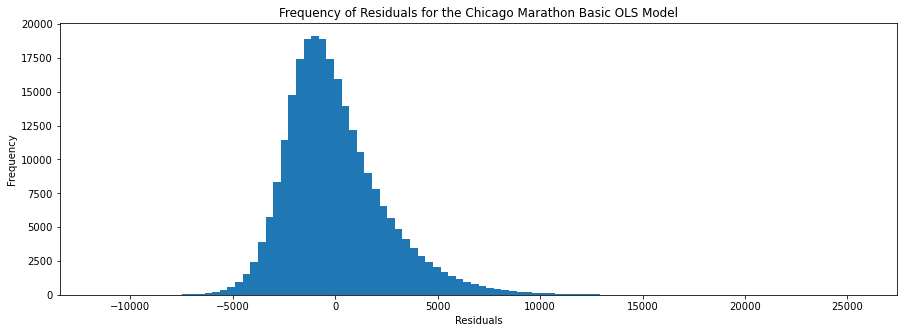

In [48]:
# Plot a histogram of the residuals
plt.figure(figsize = (15,5))
plt.hist(linreg_model_chicago_resids, bins = 100)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Frequency of Residuals for the Chicago Marathon Basic OLS Model')
plt.show()

The above histogram plot of the residuals is not a perfect normal distribution as it is slightly skewed to the right. 

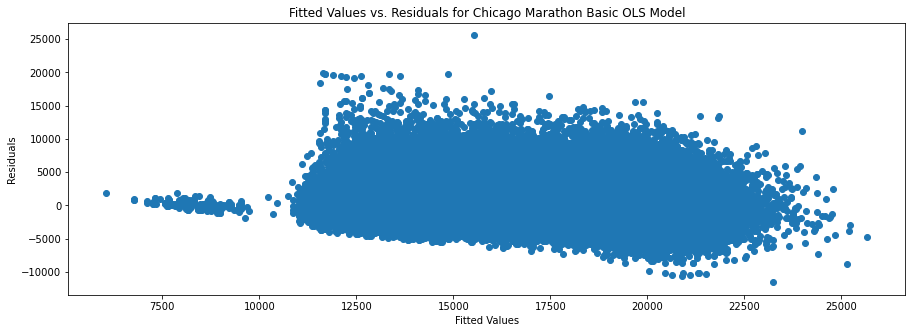

In [49]:
# Scatter plot of fitted values vs. residuals
plt.figure(figsize = (15,5))
plt.scatter(linreg_model_chicago_fittedvals, linreg_model_chicago_resids)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title ('Fitted Values vs. Residuals for Chicago Marathon Basic OLS Model')
plt.show()

The plot of the fitted values vs. the residuals does not appear totally random, although it does appear more random than the initial model for the combined marathon dataset. This lack of randomness indicates that the last assumption of the linear model (homoscedasticity) is being violated.

#### Fit the same linear model using scikit learn

In [50]:
# Create linear regression object
chicago_regr_0 = linear_model.LinearRegression()

# Train the model using the training sets
chicago_regr_0.fit(X_Chicago_remainder, y_Chicago_remainder)

# Make predictions using the testing set
chicago_y_pred = chicago_regr_0.predict(X_Chicago_test)

# Use this to look at the coefficients if desired
# print("Coefficients: \n", chicago_regr_0.coef_)

# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_Chicago_test, chicago_y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_Chicago_test, chicago_y_pred))

# Score the model 
chicago_regr_0.score(X_Chicago_test, y_Chicago_test)


Mean absolute error: 1860.26
Coefficient of determination: 0.50


0.5045423812137653

The R-Squared value from SKlearn and the OLS model were identical (0.5). The mean absolute error returned by SKlearn of 1860.30 seconds is much higher than the 647.76 seconds obtained for the London Marathon linear regression model. 

#### Try Adding L2 Regularization (Ridge Regression)
L2 Regularization encourages coefficients to be smaller. The following will only be done on the train/test split to get a sense of the effect of L2 Regularization. Hyperparameter optimization will be completed later. 

In [51]:
# Instantiate, fit, and score a Ridge Regression model
chicago_ridge_reg_0 = Ridge()
chicago_ridge_reg_0.fit(X_Chicago_remainder, y_Chicago_remainder)

print(f"Linear Regression (None) for train data: {chicago_regr_0.score(X_Chicago_test, y_Chicago_test)}")
print(f"R^2 of the Ridge Regression (L2) for train data: {chicago_ridge_reg_0.score(X_Chicago_test, y_Chicago_test)}")


Linear Regression (None) for train data: 0.5045423812137653
R^2 of the Ridge Regression (L2) for train data: 0.5045785296218983


It appears that the default Ridge Regression (loss function = the linear least squares function) with alpha of 1.0 resulted in idential performance to the basic sklearn linear model.  

In [52]:
# Instantiate, fit and score a Lasso Regression model

chicago_lasso_reg_0 = Lasso()
chicago_lasso_reg_0.fit(X_Chicago_remainder, y_Chicago_remainder)

# Evaluate Linear Regression: 
print(f"Linear Regression (None) for test data: {chicago_regr_0.score(X_Chicago_test, y_Chicago_test)}")

# Make predictions for the Linear Regression using the testing set
chicago_regr_0_y_pred = chicago_regr_0.predict(X_Chicago_test)

# Get mean absolute error for Linear Regression:
print(f"Mean Absolute Error Linear Regression for test data: {mean_absolute_error(y_Chicago_test, chicago_regr_0_y_pred)}")

# Evaluate Ridge Regression: 
print(f"R^2 of the Ridge Regression (L2) for test data: {chicago_ridge_reg_0.score(X_Chicago_test, y_Chicago_test)}")

# Make predictions for Ridge Regression using the testing set
chicago_ridge_reg_0_y_pred = chicago_ridge_reg_0.predict(X_Chicago_test)

# Get mean absolute error for Ridge Regression: 
print(f"Mean Absolute Error Ridge Regression for test data: {mean_absolute_error(y_Chicago_test, chicago_ridge_reg_0_y_pred)}")

# Evaluate Lasso Regression: 
print(f"R^2 of the Lasso Regression (L1) for test data: {chicago_lasso_reg_0.score(X_Chicago_test, y_Chicago_test)}")

# Make predictions for Lasso Regression using the testing set
chicago_lasso_reg_0_y_pred = chicago_lasso_reg_0.predict(X_Chicago_test)

# Get mean absolute error for Lasso Regression: 
print(f"Mean Absolute Error Lasso Regression for test data: {mean_absolute_error(y_Chicago_test, chicago_lasso_reg_0_y_pred)}")


Linear Regression (None) for test data: 0.5045423812137653
Mean Absolute Error Linear Regression for test data: 1860.2552300759708
R^2 of the Ridge Regression (L2) for test data: 0.5045785296218983
Mean Absolute Error Ridge Regression for test data: 1860.1693146888952
R^2 of the Lasso Regression (L1) for test data: 0.503805978142305
Mean Absolute Error Lasso Regression for test data: 1861.6046632202292


It appears that there was no improvement when using the Lasso Regression over Ridge Regression. The very minor improvement with Ridge Regression over the basic Linear Regression model was negligible when looking at both R Squared and Mean Absolute Error values.

#### Try PCR (Standard Scaler) and PLS

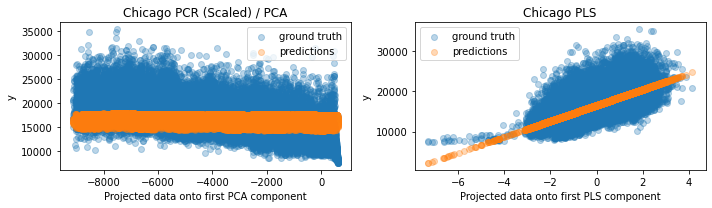

In [53]:
# Attempt Principal Component Regression and Partial Least Squares Regression

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_Chicago_train, y_Chicago_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_Chicago_train, y_Chicago_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_Chicago_validation), y_Chicago_validation, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_Chicago_validation), pcr.predict(X_Chicago_validation), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="Chicago PCR (Scaled) / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_Chicago_validation), y_Chicago_validation, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_Chicago_validation), pls.predict(X_Chicago_validation), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="Chicago PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [54]:
print(f"Chicago PCR r-squared {pcr.score(X_Chicago_test, y_Chicago_test):.3f}")
print(f"Chicago PLS r-squared {pls.score(X_Chicago_test, y_Chicago_test):.3f}")

Chicago PCR r-squared 0.055
Chicago PLS r-squared 0.448


The r-squared for PCR (Standard Scaler) doesn't seem correct, try without adding the Standard Scaler step.

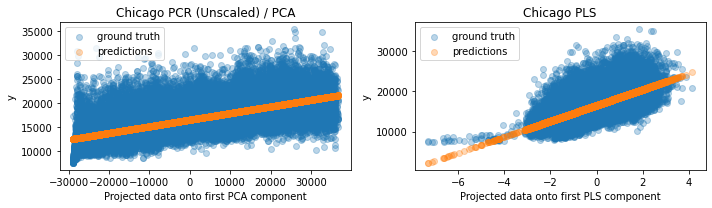

In [55]:
# Re-run the PCR and PLS from above, without using a standard scaler for PCR

pcr = make_pipeline(PCA(n_components=1), LinearRegression())
pcr.fit(X_Chicago_train, y_Chicago_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_Chicago_train, y_Chicago_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_Chicago_validation), y_Chicago_validation, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_Chicago_validation), pcr.predict(X_Chicago_validation), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="Chicago PCR (Unscaled) / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_Chicago_validation), y_Chicago_validation, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_Chicago_validation), pls.predict(X_Chicago_validation), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="Chicago PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [56]:
print(f"Chicago PCR (Unscaled) r-squared {pcr.score(X_Chicago_test, y_Chicago_test):.3f}")
print(f"Chicago PLS r-squared {pls.score(X_Chicago_test, y_Chicago_test):.3f}")

Chicago PCR (Unscaled) r-squared 0.469
Chicago PLS r-squared 0.448


Interestingly scaling with a Standard Scaler appeared to negatively impact the outcome of the PCR analysis. The score greatly improved (0.469 vs. 0.055) when using unscaled data. In contrast to the London data, the unscaled PCR outperformed the PLS, but did not perform as well as the Ridge Regression model above.  

#### Investigate Decision Tree, Random Forest, AdaBoost, Gradient Boost, and XGBoost Models

In [57]:
# Instantiate, fit and score Decision Tree, Random Forest, AdaBoost, and Gradient Boost Models

chicago_0_DT_model = DecisionTreeRegressor()
chicago_0_RF_model = RandomForestRegressor()
chicago_0_AB_model = AdaBoostRegressor()
chicago_0_grad_boost_model = GradientBoostingRegressor()

chicago_0_DT_model.fit(X_Chicago_train, y_Chicago_train)
chicago_0_RF_model.fit(X_Chicago_train, y_Chicago_train)
chicago_0_AB_model.fit(X_Chicago_train, y_Chicago_train)
chicago_0_grad_boost_model.fit(X_Chicago_train, y_Chicago_train)

print("Test Set Scores:")
print(f"Random Forest score: {chicago_0_RF_model.score(X_Chicago_validation,y_Chicago_validation)}")
print(f"Decision Tree score: {chicago_0_DT_model.score(X_Chicago_validation,y_Chicago_validation)}")
print(f"AdaBoost score: {chicago_0_AB_model.score(X_Chicago_validation,y_Chicago_validation)}")
print(f"Gradient Boost score: {chicago_0_grad_boost_model.score(X_Chicago_validation,y_Chicago_validation)}")

Test Set Scores:
Random Forest score: 0.5044551881134167
Decision Tree score: 0.20775042091601148
AdaBoost score: 0.11734529978112551
Gradient Boost score: 0.5394187730380691


The default Gradient Boost model showed improved performance (based on R-Squared values) over the Random Forest, Decision Tree and AdaBoost models. Next, I will try an XGBoost model to see if an improvement can be gained.

In [58]:
# Instantiate, fit and score a default XGBoost regression model
chicago_XGB_model_0 = XGBRegressor()
chicago_XGB_model_0.fit(X_Chicago_train, y_Chicago_train)
print(f"XGBoost score: {chicago_XGB_model_0.score(X_Chicago_validation, y_Chicago_validation)}")

XGBoost score: 0.5850368899353464


The default XGBoost model showed improved performance (R-Squared value) over the other tree based and linear regression models above. I'll proceed with exploring and attempting to optimize an XGBoost model with the Chicago Marathon results. 

### Explore an XGBoost Model

#### Try to Optimize XG Boost

#### Hyperparameters that can potentially be optimized for XGBoost
Descriptions of the hyperparameters are from the XGBoost documentation:
https://xgboost.readthedocs.io/en/latest/parameter.html

After some research, these appear to be the hyperparameters that are most commonly optimized with XGBoost models:

- eta/learning_rate:
    - Step size shrinkage used to prevent overfitting.
    - The range is 0-1. 
    - Default is set to 0.3.

- max_depth: 
    - Determines how deeply each tree is allowed to grow during any boosting round. A higher number is likely to lead to overfitting.
    - The range is 0 to infinity. 
    - Default is set to 6
    
- subsample: 
    - Percentage of training data subsampled before growing trees. Lower values can lead to underfitting.
    - The range is 0 to 1.
    - The default is 1. 
    
- colsample_bytree: 
    - percentage of features used per tree. Higher values can lead to overfitting.
    - The range is 0 to 1.
    - The default is 1. 
    
- n_estimators/num_boost_rounds: was explored above

- lambda: 
    - L2 regularization term on weights. Increasing this value will make model more conservative.
    - The default is set to 1.
    
- alpha:
    - L1 regularization term on weights. Increasing this value will make model more conservative.
    - The default is set to 0. 


NOTE: This grid search took approximately 2 hours to run. 

In [79]:
%%time

chicago_XGB_model_1 = XGBRegressor()

learning_rate_list = [0.1, 0.2, 0.5, 1.0] # Try 4 learning rates [0.1, 0.2, 0.5, 1.0]
n_estimators_list = list(range(1, 50, 5))     # Try estimators from 1 to 100, in jumps of 5

param_grid = {'n_estimators': n_estimators_list, 
              'learning_rate': learning_rate_list}

# Use default 5-fold Cross Validation
chicago_grid_xgb = GridSearchCV(chicago_XGB_model_1, param_grid=param_grid, verbose=1, n_jobs=-1)
chicago_grid_xgb.fit(X_Chicago_train, y_Chicago_train); # semicolon to prevent the gridsearch from printing itself
                                # after fitting

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 101.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 106.9min finished


CPU times: user 2min 24s, sys: 6.13 s, total: 2min 30s
Wall time: 1h 47min 55s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [ ]:
# Retrieve the score from the best model identified above
chicago_grid_xgb.score(X_Chicago_validation, y_Chicago_validation)

In [81]:
# Retreive the parameters of the best model model fitted above
chicago_grid_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=46, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

The grid search returned an optimized learning rate of 0.5 and n_estimators of 46. 

In [82]:
# Save the model identified above. 

joblib.dump(chicago_grid_xgb.best_estimator_, 'chicago_grid_xgb.pkl')

['chicago_grid_xgb.pkl']

In [84]:
# Create data frame so we can easily create visual

chicago_grid_xgb_results_df = pd.DataFrame({
    "n_estimators": chicago_grid_xgb.cv_results_["param_n_estimators"],
    'lr': chicago_grid_xgb.cv_results_["param_learning_rate"],
    'mean_score': chicago_grid_xgb.cv_results_["mean_test_score"],
})
chicago_grid_xgb_results_df


,n_estimators,lr,mean_score
0,1,0.1,-17.961525
1,6,0.1,-5.922978
2,11,0.1,-1.718247
3,16,0.1,-0.247916
4,21,0.1,0.267356
5,26,0.1,0.449363
6,31,0.1,0.514546
7,36,0.1,0.538353
8,41,0.1,0.547698
9,46,0.1,0.551396


0.1
0.2
0.5
1.0


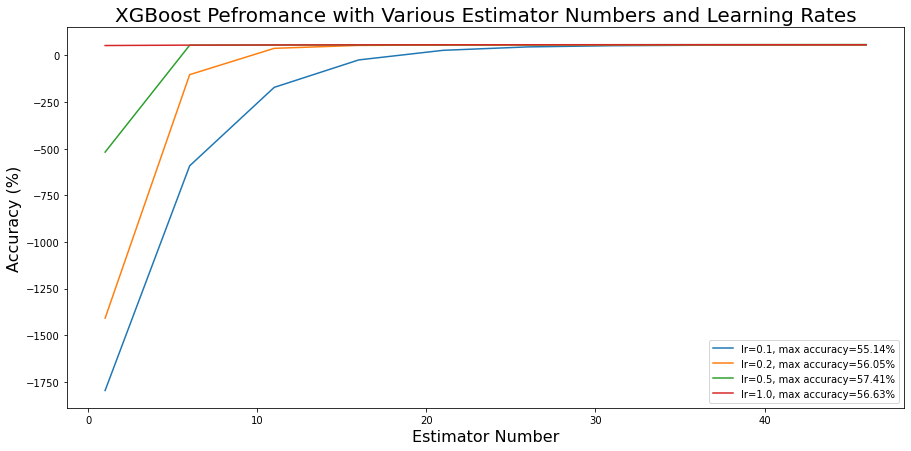

In [96]:
# Plot the XGBoost Performance (R^2) with Various Estimator Numbers and Learning Rates

plt.figure(figsize=(15,7))

for lr in chicago_grid_xgb_results_df['lr'].unique():
    lr_df = chicago_grid_xgb_results_df[chicago_grid_xgb_results_df['lr'] == lr]
    n_est = lr_df['n_estimators']
    accuracy_scores = 100*lr_df['mean_score']
    plt.plot(n_est, accuracy_scores, label=f"lr={lr}, max accuracy={round(np.max(accuracy_scores), 2)}%")

plt.title("XGBoost Pefromance with Various Estimator Numbers and Learning Rates", size=20)
plt.ylabel("Accuracy (%)", size=16)
plt.xlabel("Estimator Number", size=16)
plt.legend()
plt.show()

#### Convert the data to DMatrix objects
The DMatrix data format was specifically created for XGBoost to allow the model operate as efficiently as possible.   

See the XGBoost documentation for more information: https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [60]:
# Convert the train, validation and test sets to DMatrix objects

remainder_dmatrix = xgb.DMatrix(data = X_Chicago_remainder, label = y_Chicago_remainder)
train_dmatrix = xgb.DMatrix(data = X_Chicago_train, label = y_Chicago_train)
validation_dmatrix = xgb.DMatrix(data = X_Chicago_validation, label = y_Chicago_validation)
test_dmatrix = xgb.DMatrix(data = X_Chicago_test, label = y_Chicago_test)

#### Try out different learners: "gbtree" (default) and "gblinear"

In [88]:
# Set base learner as "booster=gbtree" (default)
# XGBoost uses regression with squared loss as the default learning objective, this will be used for the duration of working with this model

# Use a parameter dictionary to specify base learner, and the learning objective "reg:squarederror"
param_gbt = {"booster":"gbtree", "objective":"reg:squarederror"}

# num_boost_round is equivalent to the number of estimators (i.e. the number of trees built)
# this parameter will be set to 10, but is a candidate for optimization

chicago_xgb_gbtree_0 = xgb.train(params = param_gbt, dtrain = train_dmatrix, num_boost_round = 10)
chicago_pred_gbtree = chicago_xgb_gbtree_0.predict(validation_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_Chicago_validation, chicago_pred_gbtree)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  1736.563566


This mean absolute error of 1737 seconds corresponds to an error of 29 minutes. While this is the benchmark for the default model attempted with the default tree booster, a 30 minute window of error is not particularly helpful to a marathon runer. Attempts to improve the model by optimizing hyperparameters will be made below. This model did perform slightly better compared to the Linear and Ridge Regression models above, but is not close to the model obtained with the London Marathon data. 

In [86]:
# Set base learner as "booster":"gblinear"
# Parameter dictionary specifying base learner
param_gbl= {"booster":"gblinear", "objective":"reg:squarederror", "learning_rate":0.5}
  
chicago_xgb_gblinear_0 = xgb.train(params = param_gbl, dtrain = train_dmatrix, num_boost_round = 10)
chicago_pred_gblinear = chicago_xgb_gblinear_0.predict(validation_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_Chicago_validation, chicago_pred_gblinear)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  1913.275327


This mean absolute error of 1913 seconds corresponds to an error in finish time of 32 minutes. This level of error in the context of marathon finish times is not helpful for runners. Further exploration of the XGBoost model will use the default learner "gbtree" booster as this version of the model had better performance. Interestingly, the "gblinear" booster resulted in a lower mean absolute error on the Chicago data compared to the London data.  

#### Explore the initial "gbtree" model above

In [63]:
# Use a k-fold Cross Validation Using XGBoost to explore increasing the number of boost rounds (trees built)
# This model was run using the train dmatrix subset of the data
# The learning rate was set to 0.1 to match the optimal model identified in the grid search above
# Increase this to 100, but set early stopping parameter to 10
# This will take effect in the event that the model stops improving over a number of consecutive rounds

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

chicago_xgb_gbtree_0_cv_results = xgb.cv(dtrain = train_dmatrix, params=params, nfold = 5,
                    num_boost_round = 100, early_stopping_rounds = 15, metrics="mae", as_pandas=True, seed=123)

In [64]:
# By including the as_pandas = True above, dumps the Mean absolute error output for each of the rounds into a dataframe
# This allows for easy visualization 
# Print the head and tail of the data frame
print(chicago_xgb_gbtree_0_cv_results.head())
print(chicago_xgb_gbtree_0_cv_results.tail())

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0    14881.420508       2.028179   14881.416406      7.103229
1    13393.963086       1.809041   13394.026758      5.579332
2    12055.221289       1.668535   12055.302344      4.312648
3    10850.297266       1.474870   10850.413086      3.509635
4     9765.857617       1.305856    9765.937109      3.262245
    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
31     1735.108447       3.181179    1746.355908      6.666219
32     1729.750440       3.366060    1741.379883      6.430286
33     1726.354248       3.186273    1738.260132      6.765963
34     1724.166504       3.308275    1736.456519      6.487804
35     1722.623364       3.108468    1735.309253      6.811899


The train and test mean absolute errors are decreased with every boosting round with the final mean absolute error reaching 1734.3 seconds after 36 boosting rounds.  

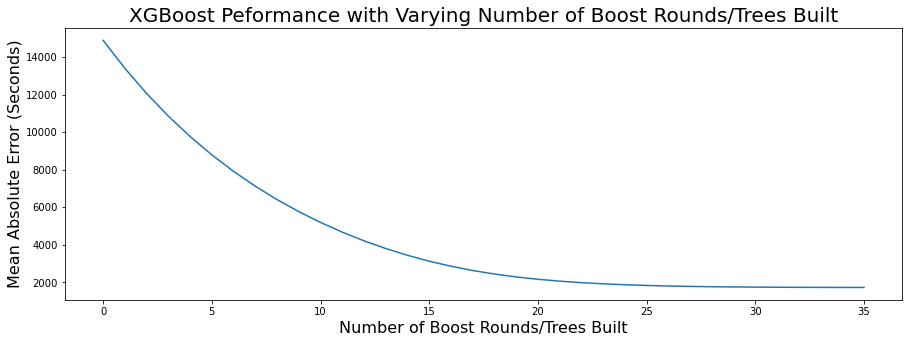

In [65]:
# Plot the mae by the number of boost rounds
plt.figure(figsize=(15,5))
    
plt.plot(chicago_xgb_gbtree_0_cv_results.index,chicago_xgb_gbtree_0_cv_results["test-mae-mean"])

plt.title("XGBoost Peformance with Varying Number of Boost Rounds/Trees Built", size=20)
plt.ylabel("Mean Absolute Error (Seconds)", size=16)
plt.xlabel("Number of Boost Rounds/Trees Built", size=16)
plt.show()

In [78]:
# Look at the Mean Absolute Error 
print((chicago_xgb_gbtree_0_cv_results["test-mae-mean"]).tail(1))

36    1734.353247
Name: test-mae-mean, dtype: float64


By increasing the number of trees/boosting rounds to 36, the model was able to decrease the mean absolute error to 1734.3 seconds (just under 29 minutes). An error rate of almost 30 minutes is not ideal for predicting marathon times. 

#### Set up and run the final model

In [94]:
# Re-train the model on the remainder set and test on the yet unseen test set 
# Use optimized hyperparameters identified above:
# learning_rate = 0.5 and n_estimators/num_boost_round = 46

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

chicago_xgb_gbtree_final = xgb.train(dtrain = remainder_dmatrix, params=params, num_boost_round = 36)
chicago_pred_gbtree_final = chicago_xgb_gbtree_final.predict(test_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_Chicago_test, chicago_pred_gbtree_final)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  1736.798920


Re-training the model on the remainder set and testing on the yet unseen testing set resulted in an increased Mean Absolute Error of 1737 seconds. 

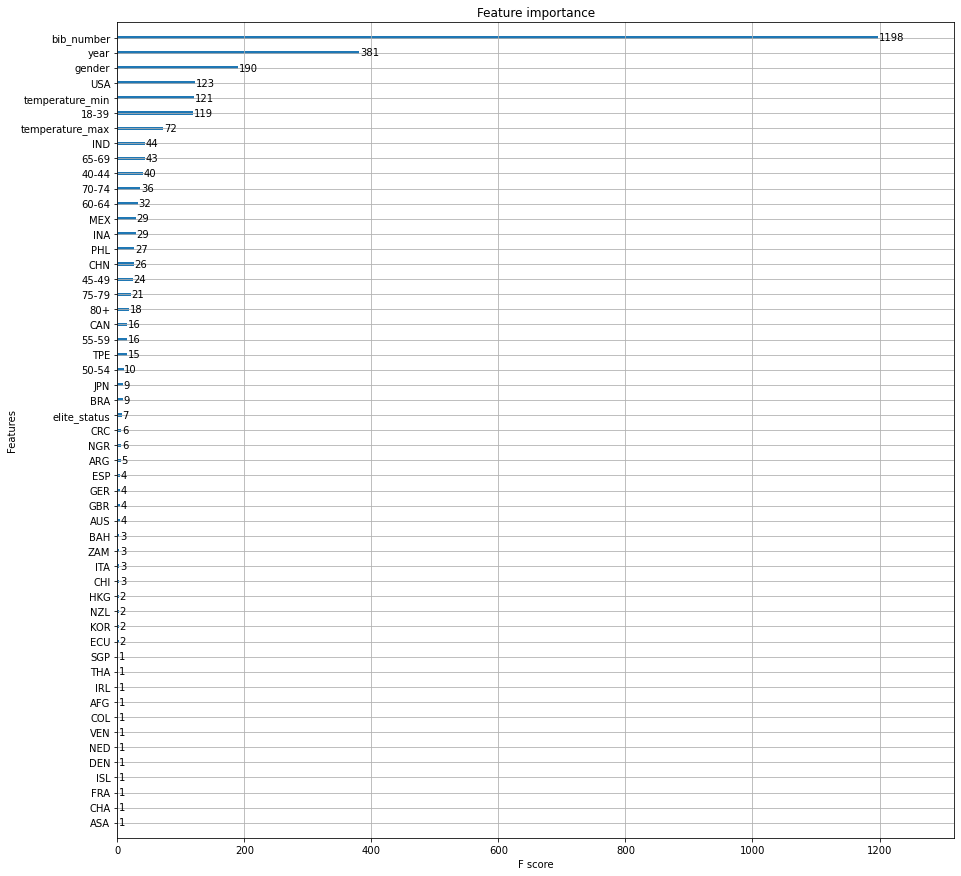

In [67]:
# Look at the importance of each feature
# This provides a full description of the factors being considered in calculating feature importance (F Score): 
# https://github.com/dmlc/xgboost/blob/b4f952b/python-package/xgboost/core.py#L1639-L1661
# NOTE: feature importance is only defined when decision tree is chosen as the base learner ("booster=gbtree"), and
# not for linear base learners (eg. "booster=gblinear")

# Plot the top features by importance
# plt.figure(figsize = (15,10))
plt.rcParams['figure.figsize'] = [15,15]
plt.rcParams['font.size'] = '10'
xgb.plot_importance(chicago_xgb_gbtree_final)
plt.show()

It's not surprising that the top predictor was bib number. Bib numbers are generally assigned based on starting placement with elite (fast) runners generally being assigned smaller bib numbers, and slower runners generally being assigned higher bib numbers. Bib number is in effect an indirect indicator of prior performance. The other top 5 important features included year, gender, USA (most Chicago runners are from the US), and minimum temperature. In an attempt to try to further improve the model, I will look at removing outliers within the dataset. 

#### Look at outliers in the finish time seconds

First, visualize outliers present in the finish_time_seconds column. 


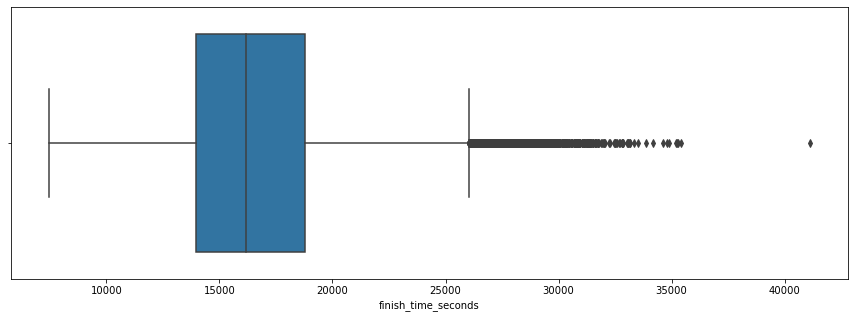

In [69]:
# Create a box plot of the finish_time_seconds feature to visualize any outliers present

plt.figure(figsize = (15,5))
sns.boxplot(x = chicago_all_features_df_ohe['finish_time_seconds'])
plt.show()

There appear to be a number of outliers in the finish time seconds column. 

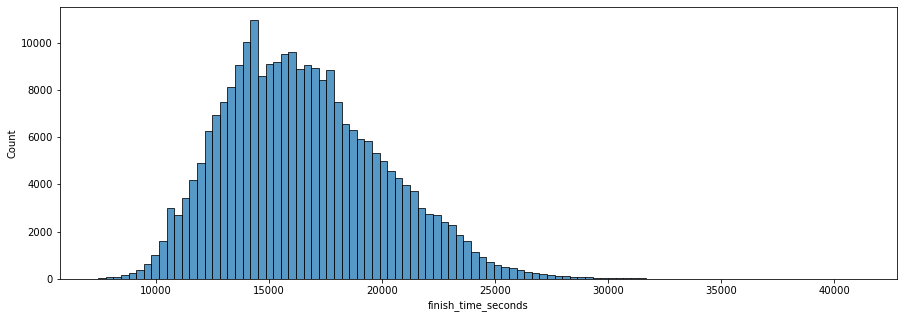

In [70]:
# Look at a histogram of the finish_time_seconds_feature

plt.figure(figsize = (15,5))
sns.histplot(chicago_all_features_df_ohe['finish_time_seconds'], bins = 100)
plt.show()

For identifying and dropping outliers, I followed this guide: https://hersanyagci.medium.com/detecting-and-handling-outliers-with-pandas-7adbfcd5cad8

This will use Tukey's rule/IQR (interquartile range) rule to detect outliers:
Steps: 
- 1 - Calculate the IQR of data: (Q3-Q1)
- 2 - Calculate the Lower Boundary: Q1–1.5 * IQR
- 3 - Calculate the Upper Boundary: Q3 + 1.5 * IQR
      

In [71]:
chicago_all_features_df_ohe[['finish_time_seconds']].describe()

,finish_time_seconds
count,253365.000000
mean,16536.336191
std,3500.913766
min,7451.000000
25%,13951.000000
50%,16176.000000
75%,18791.000000
max,41107.000000


In [72]:
# Calculate Q1, Q3 and IQR

Q1 = chicago_all_features_df_ohe['finish_time_seconds'].quantile(0.25)
print(f'Q1: {Q1}')

Q3 = chicago_all_features_df_ohe['finish_time_seconds'].quantile(0.75)
print(f'Q3: {Q3}')

IQR = Q3-Q1
print(f'IQR: {IQR}')

# Calculate the Lower and Upper Limits

lower_limit = Q1 - 1.5 * IQR
print(f'lower_limit: {lower_limit}')

upper_limit = Q3 + 1.5 * IQR
print(f'upper_limit: {upper_limit}')

Q1: 13951.0
Q3: 18791.0
IQR: 4840.0
lower_limit: 6691.0
upper_limit: 26051.0


#### Apply these limits to the data and see how many records are impacted

In [73]:
outliers_lower = (chicago_all_features_df_ohe['finish_time_seconds'] < lower_limit)

outliers_upper = (chicago_all_features_df_ohe['finish_time_seconds'] > upper_limit)

In [74]:
chicago_all_features_df_ohe[(outliers_lower|outliers_upper)]

,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
24452,2019,53374,0,0,26077,182.94,182.82,3.8,-5.9,57.91,...,0,1,0,0,0,0,0,0,0,0
24453,2019,63121,0,0,26080,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
24454,2019,51871,0,0,26097,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,1,0,0,0
24455,2019,867,0,0,26109,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
24456,2019,848,0,0,26109,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253360,2014,8148,0,1,29300,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
253361,2014,6420,0,1,29513,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,1,0,0,0,0,0,0
253362,2014,14078,0,1,29808,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,1,0,0,0,0,0,0
253363,2014,6405,0,1,29949,182.94,182.82,3.8,-5.9,57.91,...,0,0,1,0,0,0,0,0,0,0


There are 1873 outliers. All these outliers were from the upper bound (none were from the lower bound). These records will be dropped to see if any improvement can be gained. 

In [75]:
# Original number of rows
chicago_all_features_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253365 entries, 0 to 253364
Columns: 194 entries, year to 80+
dtypes: float64(9), int64(185)
memory usage: 375.0 MB


In [76]:
# Create a new dataframe with the outliers dropped
chicago_all_features_no_outliers = chicago_all_features_df_ohe[~(outliers_lower|outliers_upper)]
chicago_all_features_no_outliers


,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+
0,2019,4,1,0,7545,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
1,2019,38,1,0,7546,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
2,2019,5,1,0,7548,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
3,2019,9,1,0,7553,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
4,2019,10,1,0,7574,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253252,2014,54349,0,1,25995,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
253253,2014,53376,0,1,26000,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
253254,2014,48828,0,1,26007,182.94,182.82,3.8,-5.9,57.91,...,1,0,0,0,0,0,0,0,0,0
253255,2014,51646,0,1,26034,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,1,0,0,0,0,0


The 1873 columns were removed from the original dataset. Have a look at the distributions again and then run the model on this data. 

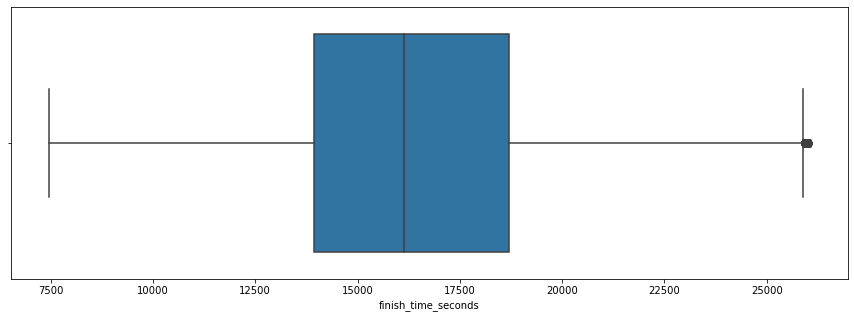

In [77]:
# Create a box plot of the finish_time_seconds feature to visualize any outliers present

plt.figure(figsize = (15,5))
sns.boxplot(x = chicago_all_features_no_outliers['finish_time_seconds'])
plt.show()

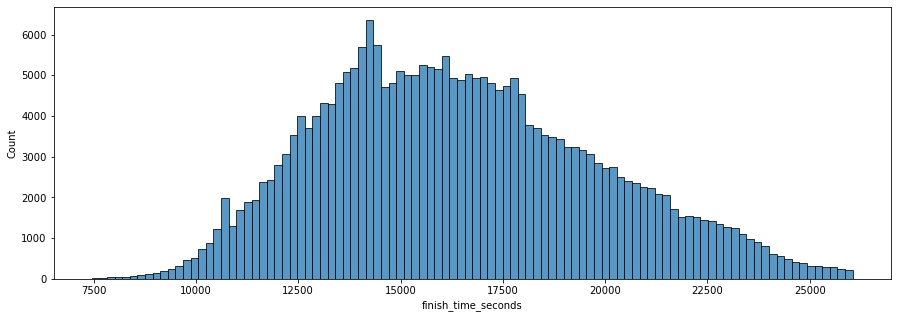

In [78]:
# Look at a histogram of the finish_time_seconds_feature

plt.figure(figsize = (15,5))
sns.histplot(chicago_all_features_no_outliers['finish_time_seconds'], bins = 100)
plt.show()

The majority of the outliers identified earlier have been removed, but some do remain. Depending on the outcome of modelling, perhaps using a factor of 2 or 2.5 (rather than 1.5) to calculate IQR could be investigated. 

#### Set up for preliminary modelling with outliers removed


In [79]:
# Set up independent and dependent variables

X_Chicago_no_outliers = chicago_all_features_no_outliers.drop('finish_time_seconds', axis = 1)
y_Chicago_no_outliers = chicago_all_features_no_outliers['finish_time_seconds']

In [80]:
# First, divide data into remainder, and test sets
# Take 20% for the test set

X_Chicago_no_outliers_remainder, X_Chicago_no_outliers_test, y_Chicago_no_outliers_remainder, y_Chicago_no_outliers_test = \
    train_test_split(X_Chicago_no_outliers, y_Chicago_no_outliers, test_size = 0.2,
                     random_state=1)

In [81]:
# Now Split the remainder into two chunks
X_Chicago_no_outliers_train, X_Chicago_no_outliers_validation, y_Chicago_no_outliers_train, y_Chicago_no_outliers_validation = \
    train_test_split(X_Chicago_no_outliers_remainder, y_Chicago_no_outliers_remainder, test_size = 0.3,
                     random_state=1)

In [82]:
# Check the shapes
print(f'Shape of test set: {X_Chicago_no_outliers_test.shape}')
print(f'Shape of validation set: {X_Chicago_no_outliers_validation.shape}')
print(f'Shape of train set: {X_Chicago_no_outliers_train.shape}')


Shape of test set: (50299, 193)
Shape of validation set: (60358, 193)
Shape of train set: (140835, 193)


In [83]:
# Look at the summary statistics in the target column for each of the sets above:
print(f'The summary statistics for y_remainder: {y_Chicago_no_outliers_remainder.describe()}')
print(f'The summary statistics for y_test: {y_Chicago_no_outliers_test.describe()}')
print(f'The summary statistics for y_train: {y_Chicago_no_outliers_train.describe()}')
print(f'The summary statistics for y_validation: {y_Chicago_no_outliers_validation.describe()}')


The summary statistics for y_remainder: count    201193.000000
mean      16451.628074
std        3377.442937
min        7451.000000
25%       13930.000000
50%       16141.000000
75%       18717.000000
max       26050.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_test: count    50299.000000
mean     16457.592397
std       3361.119596
min       7553.000000
25%      13956.000000
50%      16157.000000
75%      18690.500000
max      26048.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_train: count    140835.000000
mean      16454.774325
std        3377.503023
min        7451.000000
25%       13929.000000
50%       16136.000000
75%       18729.000000
max       26050.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_validation: count    60358.000000
mean     16444.286839
std       3377.319311
min       7472.000000
25%      13932.250000
50%      16153.000000
75%      18693.000000
max      26048.000000
Na

In [84]:
# Create linear regression object
chicago_no_outliers_regr_0 = linear_model.LinearRegression()

# Train the model using the training sets
chicago_no_outliers_regr_0.fit(X_Chicago_no_outliers_remainder, y_Chicago_no_outliers_remainder)

# Make predictions using the testing set
chicago_no_outliers_y_pred = chicago_no_outliers_regr_0.predict(X_Chicago_no_outliers_test)

# The Mean Absolute Error
print("Mean absolute error: %.2f" % mean_absolute_error(y_Chicago_no_outliers_test, chicago_no_outliers_y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_Chicago_no_outliers_test, chicago_no_outliers_y_pred))

# Score the model 
chicago_regr_0.score(X_Chicago_no_outliers_test, y_Chicago_no_outliers_test)

Mean absolute error: 1808.33
Coefficient of determination: 0.51


0.5136672903581003

Removing the outliers resulted in a similar mean absolute error to model above that included the outliers. A default XGBoost model will be run below to see if any improvement was obtained. 

#### Try an XGBoost

In [85]:
# XGBoost with outliers removed
chicago_no_outliersXGB_model_0 = XGBRegressor()
chicago_no_outliersXGB_model_0.fit(X_Chicago_no_outliers_train, y_Chicago_no_outliers_train)
print(f"XG Boost score: {chicago_no_outliersXGB_model_0.score(X_Chicago_no_outliers_validation, y_Chicago_no_outliers_validation)}")

XG Boost score: 0.5964719695712757


The XGBoost scores with and without outliers are very similar (0.59 vs. 0.60). 

In [89]:
# Convert the train, validation and test sets to DMatrix objects
remainder_no_outliers_dmatrix = xgb.DMatrix(data = X_Chicago_no_outliers_remainder, label = y_Chicago_no_outliers_remainder)
train_no_outliers_dmatrix = xgb.DMatrix(data = X_Chicago_no_outliers_train, label = y_Chicago_no_outliers_train)
validation_no_outliers_dmatrix = xgb.DMatrix(data = X_Chicago_no_outliers_validation, label = y_Chicago_no_outliers_validation)
test_no_outliers_dmatrix = xgb.DMatrix(data = X_Chicago_no_outliers_test, label = y_Chicago_no_outliers_test)


In [90]:
# Use a k-fold Cross Validation Using XGBoost to explore increasing the number of boost rounds (trees built)
# Set the learning rate to 0.1
# Increase this to 100, but set early stopping parameter to 10
# This will take effect in the event that the model stops improving over a number of consecutive rounds

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

chicago_xgb_gbtree_no_outliers_cv_results = xgb.cv(dtrain = train_no_outliers_dmatrix, params=params, nfold = 5,
                    num_boost_round = 100, early_stopping_rounds = 15, metrics="mae", as_pandas=True, seed=123)

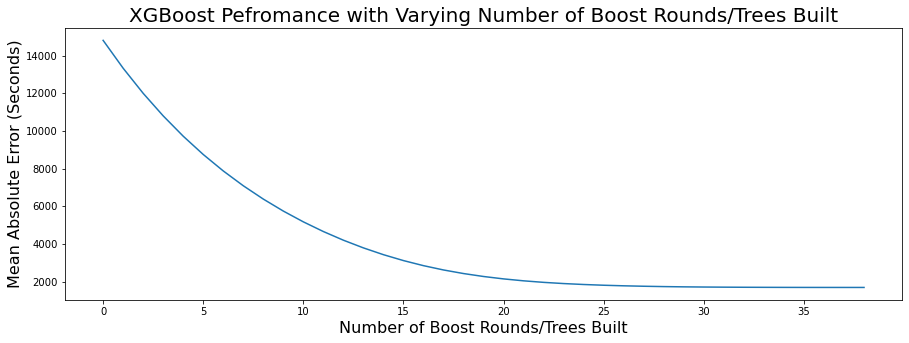

In [91]:
# Plot the mae by the number of boost rounds
plt.figure(figsize=(15,5))
    
plt.plot(chicago_xgb_gbtree_no_outliers_cv_results.index,chicago_xgb_gbtree_no_outliers_cv_results["test-mae-mean"])

plt.title("XGBoost Pefromance with Varying Number of Boost Rounds/Trees Built", size=20)
plt.ylabel("Mean Absolute Error (Seconds)", size=16)
plt.xlabel("Number of Boost Rounds/Trees Built", size=16)
plt.show()

In [92]:
# Look at the Mean Absolute Error 
print((chicago_xgb_gbtree_no_outliers_cv_results["test-mae-mean"]).tail(1))

38    1685.008984
Name: test-mae-mean, dtype: float64


Reducing outliers slightly decreased the mean absolute error from 1734 seconds to 1685 seconds. While this is an improvement, the model model is only able to predict finish times within approximately 28 minutes. At a learning rate of 0.1, the optimal number of boosting rounds for the data with outliers removed was also determined to be 38. 

In [93]:
# Re-train the model on the remainder set and test on the yet unseen test set 
# Use optimized hyperparameters identified above:
# learning_rate = 0.1 and n_estimators/num_boost_round = 38

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

chicago_no_outliers_xgb_gbtree_final = xgb.train(dtrain = remainder_no_outliers_dmatrix, params=params, num_boost_round = 38)
chicago_no_outliers_pred_gbtree_final = chicago_no_outliers_xgb_gbtree_final.predict(test_no_outliers_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_Chicago_no_outliers_test, chicago_no_outliers_pred_gbtree_final)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  1684.439007


Re-training on the remainder set and testing on the yet unseen testing set resulted in a final meal absolute error of 1684 seconds for the data with outliers removed. This was an improvement of 53 seconds over the data that included outliers. 

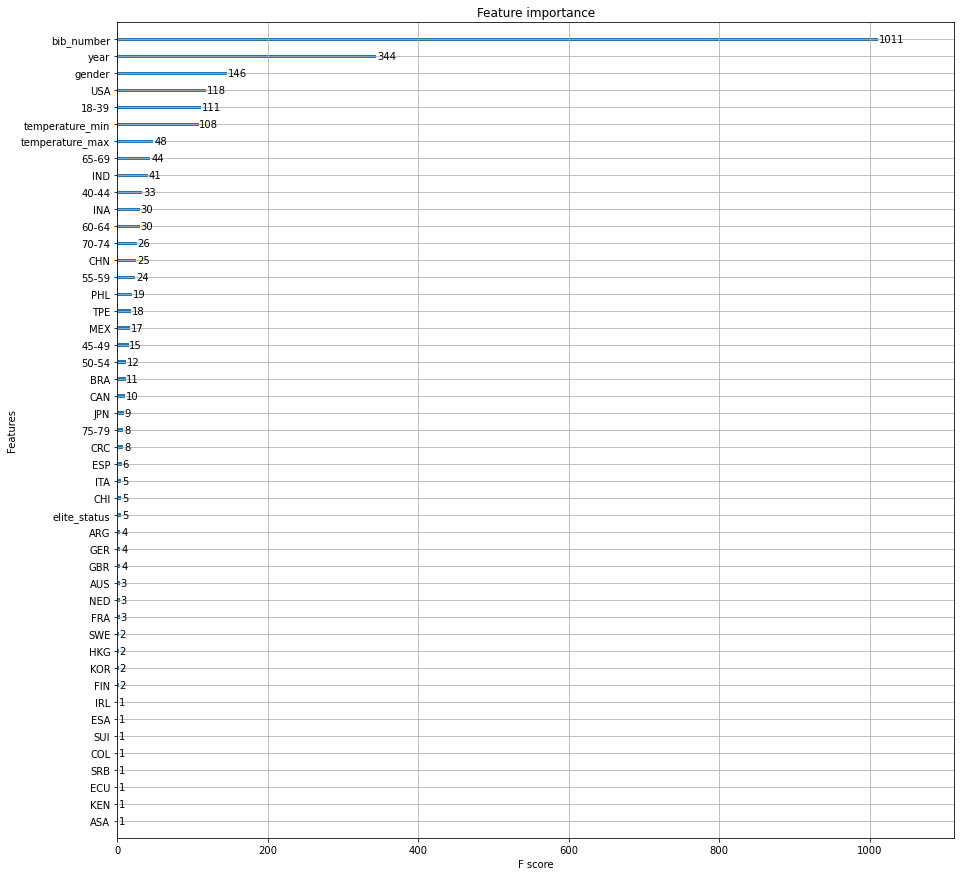

In [95]:
# Look at the importance of each feature
# This provides a full description of the factors being considered in calculating feature importance (F Score): 
# https://github.com/dmlc/xgboost/blob/b4f952b/python-package/xgboost/core.py#L1639-L1661
# NOTE: feature importance is only defined when decision tree is chosen as the base learner ("booster=gbtree"), and
# not for linear base learners (eg. "booster=gblinear")

xgb.plot_importance(chicago_no_outliers_xgb_gbtree_final)
plt.rcParams['figure.figsize'] = [30, 15]
# Increase font size of labels and axes
plt.rc('font', size=15)
plt.show()

Bib number remains the feature with the greatest importance (weight) by far. The other top 5 features include year, gender, USA (most Chicago runners are from the US) and age class (18-39). 

#### Use the model to calculate mean absolute error for all rows and add as a row in the dataframe

In [96]:
# Convert the train, validation and test sets to DMatrix objects
Chicago_no_outliers_dmatrix = xgb.DMatrix(data = X_Chicago_no_outliers, label = y_Chicago_no_outliers)

# Get Predictions in an array
x = chicago_no_outliers_xgb_gbtree_final.predict(Chicago_no_outliers_dmatrix)
x

array([ 8309.64 ,  8625.957,  8338.668, ..., 19313.027, 21227.752,
       20658.568], dtype=float32)

In [97]:
# Add the predictions as a column in the dataframe

chicago_all_features_no_outliers.loc[:,'predicted_fts'] = x
chicago_all_features_no_outliers

/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,predicted_fts
0,2019,4,1,0,7545,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,8309.639648
1,2019,38,1,0,7546,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,8625.957031
2,2019,5,1,0,7548,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,8338.667969
3,2019,9,1,0,7553,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,8309.639648
4,2019,10,1,0,7574,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,8338.667969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253252,2014,54349,0,1,25995,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,20491.548828
253253,2014,53376,0,1,26000,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,20491.548828
253254,2014,48828,0,1,26007,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,0,19313.027344
253255,2014,51646,0,1,26034,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,1,0,0,0,0,0,21227.751953


In [98]:
# Add a column that calculates Mean Absoluate Error (Actual - Predicted)
chicago_all_features_no_outliers.loc[:,'mean_abs_error'] = abs(chicago_all_features_no_outliers['finish_time_seconds'] - chicago_all_features_no_outliers['predicted_fts'])
chicago_all_features_no_outliers.head()
                                                        
                                      

/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,predicted_fts,mean_abs_error
0,2019,4,1,0,7545,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,8309.639648,764.639648
1,2019,38,1,0,7546,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,8625.957031,1079.957031
2,2019,5,1,0,7548,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,8338.667969,790.667969
3,2019,9,1,0,7553,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,8309.639648,756.639648
4,2019,10,1,0,7574,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,8338.667969,764.667969


In [99]:
# Check that there are no negative values
chicago_all_features_no_outliers['mean_abs_error'].min()

0.013671875

The model did not correctly predict any values, but was close with a minimum absolute error of 0.014.

In [100]:
chicago_all_features_no_outliers['mean_abs_error'].max()

13894.36328125

However, the worst prediction by the model was off by almost 4 hours!

In [101]:
# Investigate mean absolute error by year
chicago_all_features_no_outliers.groupby('year').mean()

,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,predicted_fts,mean_abs_error
year,,,,,,,,,,,,,,,,,,,,,
2014,26156.129411,0.001162,0.452482,16342.627223,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0.107748,0.073967,0.040779,0.017929,0.006380,0.001632,0.000495,0.000074,16032.329102,1494.481509
2015,25684.450504,0.001069,0.460683,16463.237529,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0.118310,0.079542,0.041895,0.019264,0.006680,0.001950,0.000321,0.000107,16157.202148,1710.998843
2016,27214.015400,0.000646,0.455390,16402.621237,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0.120194,0.081172,0.046324,0.021411,0.008048,0.002111,0.000447,0.000124,16094.797852,1508.318266
2017,29945.508045,0.000731,0.482151,17096.723466,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0.136964,0.088514,0.049250,0.023288,0.008547,0.002423,0.000366,0.000160,16733.546875,1797.410475
2018,30857.631980,0.000929,0.461294,16329.294779,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0.134087,0.095110,0.054976,0.027307,0.010379,0.002923,0.000703,0.000181,16067.042969,1762.992054
2019,31799.128595,0.000704,0.462404,16087.053821,182.94,182.82,3.8,-5.9,57.91,-58.03,...,0.134267,0.098474,0.055294,0.026537,0.009542,0.002990,0.000484,0.000110,15829.255859,1742.531105


The lowest mean absolute error by year was for 2014 (1494 seconds) and the highest was for 2017 (1797 seconds). 

In [103]:
# Investigate the mean absolute error by gender
chicago_all_features_no_outliers.groupby('gender')[['finish_time_seconds','predicted_fts','mean_abs_error']].mean()

,finish_time_seconds,predicted_fts,mean_abs_error
gender,,,
0,15669.838686,15410.358398,1645.358296
1,17362.148421,17013.917969,1706.397831


The mean absolute error was higher for females vs. males, in contrast to the results from the London model. 

In [105]:
# Investigate the mean absolute error by age category
chicago_all_features_no_outliers.groupby(['18-39', '40-44','45-49','50-54','55-59','60-64','65-69', '70-74', '75-79'])[['finish_time_seconds','predicted_fts','mean_abs_error']].mean()

finish_time_seconds  \
18-39 40-44 45-49 50-54 55-59 60-64 65-69 70-74 75-79                        
0     0     0     0     0     0     0     0     0             21586.531250   
                                                1             20398.764706   
                                          1     0             19696.877311   
                                    1     0     0             18736.883699   
                              1     0     0     0             17822.376372   
                        1     0     0     0     0             17164.480703   
                  1     0     0     0     0     0             16746.545421   
            1     0     0     0     0     0     0             16515.457508   
      1     0     0     0     0     0     0     0             16273.627973   
1     0     0     0     0     0     0     0     0             16270.057529   

                                                       predicted_fts  \
18-39 40-44 45-49 50-54 55-59 60-64 65-69 70-74 75-79                  
0     0     0     0     0     0     0     0     0       18835.257812   
                                                1       18258.398438   
                                          1     0       18532.677734   
                                    1     0     0       18041.138672   
                              1     0     0     0       17245.902344   
                        1     0     0     0     0       16687.765625   
                  1     0     0     0     0     0       16362.035156   
            1     0     0     0     0     0     0       16216.833984   
      1     0     0     0     0     0     0     0       16027.351562   
1     0     0     0     0     0     0     0     0       16005.733398   

                                                       mean_abs_error  
18-39 40-44 45-49 50-54 55-59 60-64 65-69 70-74 75-79                  
0     0     0     0     0     0     0     0     0         3265.860321  
                                                1         2773.377552  
                                          1     0         2025.975983  
                                    1     0     0         1876.166872  
                              1     0     0     0         1760.353515  
                        1     0     0     0     0         1657.848131  
                  1     0     0     0     0     0         1637.289132  
            1     0     0     0     0     0     0         1626.651417  
      1     0     0     0     0     0     0     0         1601.660215  
1     0     0     0     0     0     0     0     0         1702.731772

The highest mean absolute error was for the 75-79 group. Interestingly, the 40-44 age category also had lower mean absolute error, even with a higher number of runners, similar to the absolute mean errors for the London Marathon Model. 

In [106]:
chicago_all_features_no_outliers.groupby('elite_status')[['finish_time_seconds','predicted_fts','mean_abs_error']].mean()

,finish_time_seconds,predicted_fts,mean_abs_error
elite_status,,,
0,16459.764548,16158.527344,1674.583243
1,8449.403670,8949.569336,539.710875


The model appeared to predict quite well on average for elite runners as compared to non elite runners. The mean absolute error for elites was 539.71 seconds which is just under 9 minutes. 

#### Look at how the model scored my finish times

In [111]:
# 2014
chicago_all_features_no_outliers[(chicago_all_features_no_outliers['bib_number']==21803) & (chicago_all_features_no_outliers['year']==2014)]


,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,predicted_fts,mean_abs_error
238420,2014,21803,0,1,14353,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,15573.182617,1220.182617


The model did not perform well on my 2014 results. The model's prediction added an extra 20 minutes to my finish time. 

In [112]:
# 2017
chicago_all_features_no_outliers[(chicago_all_features_no_outliers['bib_number']==23485) & (chicago_all_features_no_outliers['year']==2017)]

,year,bib_number,elite_status,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80+,predicted_fts,mean_abs_error
158736,2017,23485,0,1,15289,182.94,182.82,3.8,-5.9,57.91,...,0,0,0,0,0,0,0,0,15783.916016,494.916016


The model actually showed improved performance on my 2017 result. The prediction only added an extra 8 minutes to my finish time. 

#### Conclusions

I found that an using an XGBoost model on a dataset with outliers removed provide the best performing model with the Chicago data. The model was able to predict finish times within approximately 1684 seconds (approximately 28 minutes). While I was able to achieve slight improvement over the base model, this level of error in the final model is not helpful for marathon runners. Without half-split time as an available feature in the model, the model was less able to predict finish times as compared to the model developed using the London data. It would be worthwhile to try and retrieve half-split data for the Chicago marathon results and re-run the data to see if improved performances comparable to the London model could be obtained. 